In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

theme, cs = rp.mpl_setup(False)

In [2]:
#  -U git+https://github.com/CompRhys/aviary.git

In [3]:
df = pd.read_feather('pairs_data.feather')
df

,ratio,dist,id_1,pretty_formula_1,space_group_1,id_2,pretty_formula_2,space_group_2
0,5:3,0.075454,mp-31172,Ca5Ag3,I4/mcm,mp-571212,Yb5Ag3,I4/mcm
1,5:3,2.008706,mp-31172,Ca5Ag3,I4/mcm,mp-1501,Al3Pt5,Pbam
2,5:3,2.300419,mp-31172,Ca5Ag3,I4/mcm,mp-16514,Al3Ni5,Cmmm
3,5:3,1.506156,mp-31172,Ca5Ag3,I4/mcm,mp-10047,Ca5As3,P6_3/mcm
4,5:3,1.428876,mp-31172,Ca5Ag3,I4/mcm,mp-1106024,Eu5As3,P6_3/mcm
...,...,...,...,...,...,...,...,...
15063717,2:1:1,0.061459,mp-999137,SmTlSe2,R-3m,mp-1065514,YTlTe2,R-3m
15063718,2:1:1,2.728159,mp-999137,SmTlSe2,R-3m,mp-1187870,YTmTl2,Fm-3m
15063719,2:1:1,0.122831,mp-1008561,TmTlTe2,R-3m,mp-1065514,YTlTe2,R-3m
15063720,2:1:1,2.711075,mp-1008561,TmTlTe2,R-3m,mp-1187870,YTmTl2,Fm-3m


In [4]:
import torch
import torch.nn.functional as F
from aviary.roost.model import DescriptorNetwork
from pymatgen.core import Composition
from torch import Tensor, LongTensor
from data import collate_batch, comp2graph

device = 'cuda'
torch.set_default_device(device)



elem_embed_dim = 112
comp_embed_dim = 64

batch = collate_batch([comp2graph(x) for x in df.sample(16)['pretty_formula_1']])
print([tuple(x.shape) for x in batch])

gnn = DescriptorNetwork(elem_emb_len=elem_embed_dim, elem_fea_len=64)

out = gnn(*batch)

print(out.shape)
out

[(48, 1), (48, 112), (146,), (146,), (48,)]
torch.Size([16, 64])


tensor([[ 0.0504, -0.0275,  0.0036,  ...,  0.0029,  0.0169, -0.0143],
        [ 0.0412, -0.0212,  0.0079,  ..., -0.0001,  0.0131, -0.0096],
        [ 0.0494, -0.0290,  0.0109,  ..., -0.0036,  0.0195, -0.0189],
        ...,
        [ 0.0435, -0.0354,  0.0038,  ..., -0.0018,  0.0208, -0.0092],
        [ 0.0464, -0.0308,  0.0035,  ..., -0.0044,  0.0219, -0.0105],
        [ 0.0464, -0.0250,  0.0073,  ..., -0.0126,  0.0191, -0.0093]],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [5]:
benchmark = pd.read_csv('https://raw.githubusercontent.com/usccolumbia/cspbenchmark/main/data/CSPbenchmark_test_data.csv')
benchmark_ids = benchmark['material_id']

In [6]:
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader, random_split, IterableDataset
from tqdm import tqdm, trange

fn = 'ds-oh.pt'
regen = False

val_frac = 0.1
test_frac = 0.5
batch_size = 256
shard_size = 256
df_train = df.iloc[::1].query('dist > 0.01')
print(df_train.shape)
df_train = df_train.query('id_1 not in @benchmark_ids and id_2 not in @benchmark_ids')
print(df_train.shape)
df_train = df_train.iloc[:-(df_train.shape[0] % batch_size)]
print(df_train.shape)


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X1, X2, y):
        self.X1 = X1
        self.X2 = X2
        self.y = y
    def __len__(self):
        return len(self.X1)
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]
if regen:
    X1 = []
    X2 = []
    y = []
    for i in trange(0, len(df_train.index), batch_size):
        df_batch = df_train.iloc[i:i+batch_size]
        X1.append(collate_batch([comp2graph(x) for x in df_batch['pretty_formula_1']]))
        X2.append(collate_batch([comp2graph(x) for x in df_batch['pretty_formula_2']]))
        y.append(torch.tensor(df_batch['dist'].values))

        if (i // batch_size + 1) % shard_size == 0:
            ds = MyDataset(X1, X2, y)
            torch.save(ds, Path('full_dataset') / f'{(i // batch_size +1) // shard_size}.pt')
            X1 = []
            X2 = []
            y = []

    ds = MyDataset(X1, X2, y)
    torch.save(ds, Path('full_dataset') / '0.pt')
else:
    # ds = torch.load(fn, weights_only=False)
    dses = []
    shards = sorted(Path('full_dataset').glob('*.pt'))
    train_len = int((1 - test_frac) * len(shards))    
    train_shards = shards[:train_len]
    test_shards = shards[train_len:]
    for shard in tqdm(train_shards):
        dses.append(torch.load(shard, weights_only=False))
    
    ds = torch.utils.data.ConcatDataset(dses)
    

train_ds, val_ds = random_split(ds, [1 - val_frac, val_frac], generator=torch.Generator(device=device).manual_seed(123))
train_dl = DataLoader(train_ds, batch_size=None, shuffle=True, generator=torch.Generator(device=device))
val_dl = DataLoader(val_ds, batch_size=None)
val_X1, val_X2, val_y = next(iter(val_dl))

(11933266, 8)
(11833367, 8)
(11833344, 8)


100%|██████████| 90/90 [00:35<00:00,  2.55it/s]


In [8]:
lr = 1e-3
num_epochs = 5
tau = 1.0
elem_embed_dim: int = 64
comp_embed_dim: int = 64
torch.set_float32_matmul_precision('high')

In [ ]:
from tqdm import trange
from model import CompositionEmbedding


hist = []
model = CompositionEmbedding(elem_input_dim=112, elem_hidden_dim=elem_embed_dim, comp_embed_dim=comp_embed_dim, rescale_init=48, n_graph=1)
model = torch.load('checkpoints/exp.pt', weights_only=False).to(device)
# z1 = model.embed(val_X1)
# z2 = model.embed(val_X2)
# print(torch.linalg.vector_norm(z1 - z2, dim=1))

# print(model.rescale)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_epochs)

with trange(num_epochs * len(train_dl)) as bar:
    for epoch in range(num_epochs):
        model.train()
        loss_vals = []
        for X1, X2, y in train_dl:
            bar.update()            
            loss_val = F.binary_cross_entropy(model(X1, X2), (y < tau).float())
            loss_val.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_vals.append(loss_val.detach().item())
            if (bar.n + 1) % 100 == 0:
                bar.set_description_str('Train: {:.3f} Valid: {:.3f}'.format(np.mean(loss_vals[-100:]),  hist[-1]["Validation Loss"] if hist else 0))
        model.eval()
        with torch.no_grad():
            val_losses = []
            for X1, X2, y in val_dl:
                val_losses.append(F.binary_cross_entropy(model(X1, X2), (y < tau).float()))

            val_losses = torch.tensor(val_losses)
        hist.append({
            'Epoch': epoch,
            'Train Loss': sum(loss_vals) / len(loss_vals),
            'Validation Loss': val_losses.mean().item()
        })
        torch.save(model, 'checkpoints/ckpt.pt')

        print({k: f'{v:.4f}' for k, v in hist[-1].items()})

        bar.set_description_str('Train: {:.3f} Valid: {:.3f}'.format(hist[-1]["Train Loss"], hist[-1]["Validation Loss"]))
        scheduler.step()

hist = pd.DataFrame(hist)

sns.lineplot(hist, x='Epoch', y='Train Loss')
sns.lineplot(hist, x='Epoch', y='Validation Loss')

Train: 0.128 Valid: 0.110:  20%|██        | 20642/103180 [07:57<18:47:29,  1.22it/s]

{'Epoch': '0.0000', 'Train Loss': '0.1277', 'Validation Loss': '0.1098'}


Train: 0.089 Valid: 0.082:  40%|████      | 41277/103180 [15:57<17:38:17,  1.03s/it]

{'Epoch': '1.0000', 'Train Loss': '0.0889', 'Validation Loss': '0.0817'}


Train: 0.101 Valid: 0.082:  43%|████▎     | 44257/103180 [17:21<21:56, 44.75it/s]   

In [18]:
model = torch.load('checkpoints/exp2.pt')

/tmp/ipykernel_2912814/1033193543.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('checkpoints/exp2.pt')


In [19]:
ypred = []
ytrue = []
model.eval()
with torch.no_grad():
    for (X1, X2, y), _ in zip(val_dl, range(1000)):
        ypred.append(model(X1, X2).detach().cpu())
        ytrue.append(y.cpu())

ypred = torch.cat(ypred)
ytrue = torch.cat(ytrue) < tau

In [21]:
print(((ypred > 0.5) == ytrue).float().mean())
print(torch.corrcoef(torch.vstack([ypred > 0.5, ytrue]).float()))

tensor(0.9680)
tensor([[1.0000, 0.6571],
        [0.6571, 1.0000]])


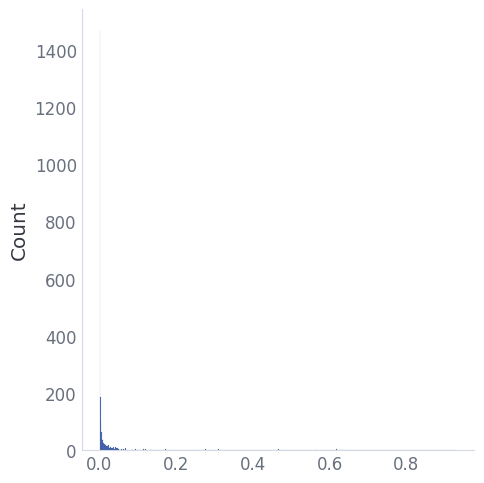

In [13]:
sns.displot(ypred[::100].numpy(force=True))

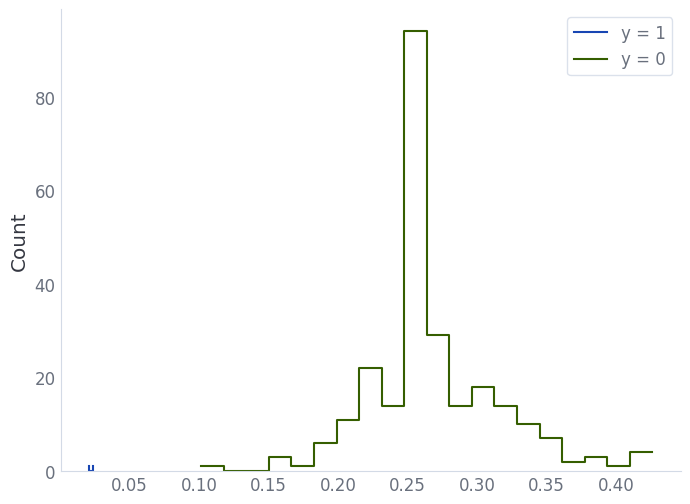

In [14]:
dists = torch.linalg.vector_norm(model.embed(X1) - model.embed(X2), dim=1).numpy(force=True)
y_np = y.numpy(force=True) < tau

sns.histplot(x=dists[y_np], label='y = 1', fill=False, element='step', bins=20)
sns.histplot(x=dists[~y_np], label='y = 0', fill=False, element='step', bins=20)
plt.legend()

- train from CIF folder
- oxidation state (BERTOS), make nodes

In [ ]:
mp_id = 'mp-5615'

df_id = df.query('id_1 == @mp_id')

X1 = collate_batch([comp2graph(df_id['pretty_formula_1'].iloc[0])])

x2s = df_id['pretty_formula_2']

X2 = []
for i in range(0, x2s.shape[0], batch_size):
    X2.append(collate_batch([comp2graph(c) for c in x2s.iloc[i:i+batch_size]]))

model.eval()
z1 = model.embed(X1)
z2 = torch.cat([model.embed(x) for x in X2])

dists = torch.cdist(z1, z2)
df_id['z_dist'] = dists.numpy(force=True).reshape(-1)

In [ ]:
df_id.sort_values('z_dist')

In [ ]:
torch.save(model, 'checkpoints/exp-2.pt')